# Unzip the data

In [37]:
zip_file_path = "./archive.zip"
destination_path = "brain_tumor_images"
input_path = './archive/segmentation/'
model_path = 'unet.hdf5'
train_result_file_path = 'train_history_info.csv'
test_result_file_path = 'test_history_info.csv'
loss_img = 'loss_function.png'
dsc_img = 'dice_coeff.png'
iou_img = 'jaccard_coeff.png'



In [38]:
# setting size parameter of images
im_width = 256
im_height = 256
channel = 3

# Loading data from directory and separating actual brain images and masked images

In [39]:
from glob import glob


input_path = input_path

image_filenames_train = []
mask_files = glob(input_path+'*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train)

['./archive/segmentation\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', './archive/segmentation\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', './archive/segmentation\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', './archive/segmentation\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', './archive/segmentation\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', './archive/segmentation\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', './archive/segmentation\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', './archive/segmentation\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', './archive/segmentation\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_18.tif', './archive/segmentation\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_19.tif']


3929

# Contains plotting images and dice and IoU calculating functions

In [40]:


import matplotlib.image as mpimg

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import matplotlib.image as mpimg
import cv2
from tensorflow.keras import backend as K
from skimage.color import rgb2gray
from skimage.io import imread, imshow, concatenate_images


def plot_from_train_image(rows, columns, list_img_path):
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
#         mpimg.imsave('my_image_copy.png', image)

def plot_from_mask_image(rows, columns, list_mask_path):
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)

def plot_from_img(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)
        # mpimg.imsave('my_image_copy.png', image)
        

def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)


def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)


def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou


def jaccard_distance(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    return -iou(y_true_flatten, y_pred_flatten)


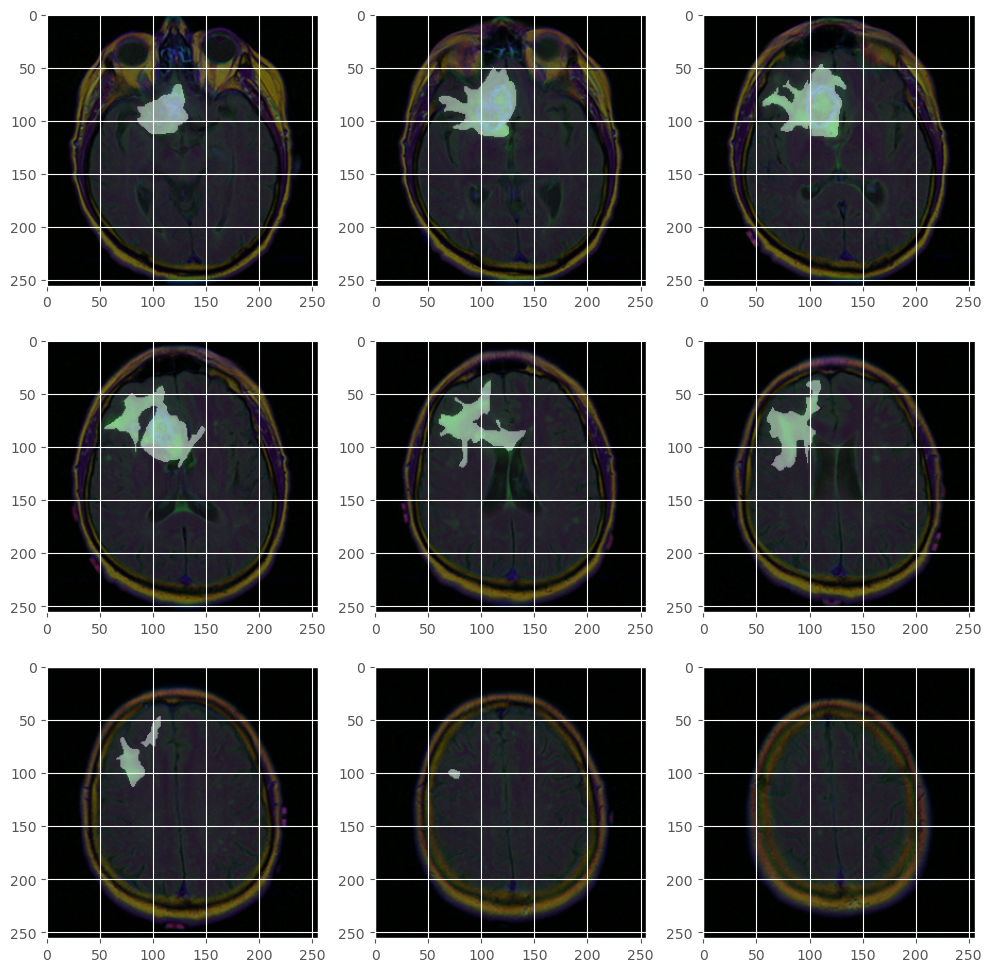

In [41]:
plot_from_img(3,3, image_filenames_train, mask_files)

# Splitting train, test and validation data

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split


df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })
# shuffle the DataFrame
df = df.sample(frac=1)
df = df.reset_index(drop=True)

df_train, df_test = train_test_split(df, test_size=0.3)

# validation dataset
df_test, df_val = train_test_split(df_test, test_size=0.5)


print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2750, 2)
(589, 2)
(590, 2)


# Creating U-Net Model

In [43]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    concatenate,
    Dropout,
)

def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    conv1 = Conv2D(filters=48, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    conv1 = Conv2D(filters=48, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=96, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    conv2 = Conv2D(filters=96, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=192, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    conv3 = Conv2D(filters=192, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=384, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    conv4 = Conv2D(filters=384, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=768, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)
    conv5 = Conv2D(filters=768, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)
    drop5 = Dropout(0.5)(bn5)  # Add dropout

    up6 = concatenate(
        [
            Conv2DTranspose(384, kernel_size=(2, 2), strides=(2, 2), padding="same")(drop5),
            conv4,
        ],
        axis=3,
    )
    conv6 = Conv2D(filters=384, kernel_size=(3, 3), padding="same")(up6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)
    conv6 = Conv2D(filters=384, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)
    drop6 = Dropout(0.5)(bn6)  # Add dropout

    up7 = concatenate(
        [
            Conv2DTranspose(192, kernel_size=(2, 2), strides=(2, 2), padding="same")(drop6),
            conv3,
        ],
        axis=3,
    )
    conv7 = Conv2D(filters=192, kernel_size=(3, 3), padding="same")(up7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)
    conv7 = Conv2D(filters=192, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)
    drop7 = Dropout(0.5)(bn7)  # Add dropout

    up8 = concatenate(
        [
            Conv2DTranspose(96, kernel_size=(2, 2), strides=(2, 2), padding="same")(drop7),
            conv2,
        ],
        axis=3,
    )
    conv8 = Conv2D(filters=96, kernel_size=(3, 3), padding="same")(up8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)
    conv8 = Conv2D(filters=96, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)
    drop8 = Dropout(0.5)(bn8)  # Add dropout

    up9 = concatenate(
        [
            Conv2DTranspose(48, kernel_size=(2, 2), strides=(2, 2), padding="same")(drop8),
            conv1,
        ],
        axis=3,
    )
    conv9 = Conv2D(filters=48, kernel_size=(3, 3), padding="same")(up9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)
    conv9 = Conv2D(filters=48, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=inputs, outputs=conv10)

# Data Augmentation, Data Generator related functions

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)
        

In [45]:
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

# Hyperparameters

In [46]:
EPOCHS = 100
BATCH_SIZE = 6
lr = 1e-4
smooth=100

In [47]:
model = unet()
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_114 (Conv2D)            (None, 256, 256, 48  1344        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_108 (Batch  (None, 256, 256, 48  192        ['conv2d_114[0][0]']             
 Normalization)                 )                                                           

In [48]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

patience = 10

early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
train_generator_param = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_gen = train_generator(
    df_train,
    BATCH_SIZE,
    train_generator_param,
    target_size=(im_height, im_width)
)

val_gen = train_generator(
    df_val,
    BATCH_SIZE,
    dict(),
    target_size=(im_height, im_width)
)

model = unet(input_size=(im_height, im_width, 3))

opt = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=True)

model.compile(
    optimizer=opt,
    loss=dice_coefficients_loss,
    metrics=["binary_accuracy", iou, dice_coefficients]
)

model_path = "model_savedmodel"  # Define the path to save the model

model_checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=True)

history = model.fit(
    train_gen,
    steps_per_epoch=len(df_train) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[model_checkpoint, early_stopping],
    validation_data=val_gen,
    validation_steps=len(df_val) // BATCH_SIZE
)

Found 2750 validated image filenames.
Found 2750 validated image filenames.
Epoch 1/100
458/458 [==============================] - ETA: 0s - loss: -0.0789 - binary_accuracy: 0.9160 - iou: 0.0428 - dice_coefficients: 0.0789Found 590 validated image filenames.
Found 590 validated image filenames.

Epoch 1: val_loss improved from inf to -0.04924, saving model to model_savedmodel


INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 172s 357ms/step - loss: -0.0789 - binary_accuracy: 0.9160 - iou: 0.0428 - dice_coefficients: 0.0789 - val_loss: -0.0492 - val_binary_accuracy: 0.6430 - val_iou: 0.0259 - val_dice_coefficients: 0.0492
Epoch 2/100
458/458 [==============================] - ETA: 0s - loss: -0.1455 - binary_accuracy: 0.9751 - iou: 0.0833 - dice_coefficients: 0.1459
Epoch 2: val_loss improved from -0.04924 to -0.15348, saving model to model_savedmodel


INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 201s 433ms/step - loss: -0.1455 - binary_accuracy: 0.9751 - iou: 0.0833 - dice_coefficients: 0.1459 - val_loss: -0.1535 - val_binary_accuracy: 0.9383 - val_iou: 0.0880 - val_dice_coefficients: 0.1535
Epoch 3/100
458/458 [==============================] - ETA: 0s - loss: -0.2753 - binary_accuracy: 0.9865 - iou: 0.1746 - dice_coefficients: 0.2756
Epoch 3: val_loss improved from -0.15348 to -0.38139, saving model to model_savedmodel


INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 175s 382ms/step - loss: -0.2753 - binary_accuracy: 0.9865 - iou: 0.1746 - dice_coefficients: 0.2756 - val_loss: -0.3814 - val_binary_accuracy: 0.9932 - val_iou: 0.2602 - val_dice_coefficients: 0.3814
Epoch 4/100
458/458 [==============================] - ETA: 0s - loss: -0.4180 - binary_accuracy: 0.9910 - iou: 0.2920 - dice_coefficients: 0.4174
Epoch 4: val_loss improved from -0.38139 to -0.43524, saving model to model_savedmodel


INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 173s 378ms/step - loss: -0.4180 - binary_accuracy: 0.9910 - iou: 0.2920 - dice_coefficients: 0.4174 - val_loss: -0.4352 - val_binary_accuracy: 0.9935 - val_iou: 0.3176 - val_dice_coefficients: 0.4352
Epoch 5/100
458/458 [==============================] - ETA: 0s - loss: -0.5207 - binary_accuracy: 0.9930 - iou: 0.3936 - dice_coefficients: 0.5207
Epoch 5: val_loss improved from -0.43524 to -0.54734, saving model to model_savedmodel


INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 165s 360ms/step - loss: -0.5207 - binary_accuracy: 0.9930 - iou: 0.3936 - dice_coefficients: 0.5207 - val_loss: -0.5473 - val_binary_accuracy: 0.9937 - val_iou: 0.4258 - val_dice_coefficients: 0.5473
Epoch 6/100
458/458 [==============================] - ETA: 0s - loss: -0.5771 - binary_accuracy: 0.9938 - iou: 0.4518 - dice_coefficients: 0.5764
Epoch 6: val_loss improved from -0.54734 to -0.57670, saving model to model_savedmodel


INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 168s 365ms/step - loss: -0.5771 - binary_accuracy: 0.9938 - iou: 0.4518 - dice_coefficients: 0.5764 - val_loss: -0.5767 - val_binary_accuracy: 0.9946 - val_iou: 0.4633 - val_dice_coefficients: 0.5767
Epoch 7/100
458/458 [==============================] - ETA: 0s - loss: -0.6101 - binary_accuracy: 0.9944 - iou: 0.4885 - dice_coefficients: 0.6104
Epoch 7: val_loss did not improve from -0.57670
458/458 [==============================] - 164s 357ms/step - loss: -0.6101 - binary_accuracy: 0.9944 - iou: 0.4885 - dice_coefficients: 0.6104 - val_loss: -0.5612 - val_binary_accuracy: 0.9940 - val_iou: 0.4505 - val_dice_coefficients: 0.5612
Epoch 8/100
458/458 [==============================] - ETA: 0s - loss: -0.6238 - binary_accuracy: 0.9945 - iou: 0.5083 - dice_coefficients: 0.6230
Epoch 8: val_loss improved from -0.57670 to -0.62300, saving model to model_savedmodel


INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 170s 372ms/step - loss: -0.6238 - binary_accuracy: 0.9945 - iou: 0.5083 - dice_coefficients: 0.6230 - val_loss: -0.6230 - val_binary_accuracy: 0.9943 - val_iou: 0.5097 - val_dice_coefficients: 0.6230
Epoch 9/100
458/458 [==============================] - ETA: 0s - loss: -0.6380 - binary_accuracy: 0.9946 - iou: 0.5228 - dice_coefficients: 0.6383
Epoch 9: val_loss improved from -0.62300 to -0.62611, saving model to model_savedmodel


INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 168s 365ms/step - loss: -0.6380 - binary_accuracy: 0.9946 - iou: 0.5228 - dice_coefficients: 0.6383 - val_loss: -0.6261 - val_binary_accuracy: 0.9944 - val_iou: 0.5131 - val_dice_coefficients: 0.6261
Epoch 10/100
458/458 [==============================] - ETA: 0s - loss: -0.6438 - binary_accuracy: 0.9952 - iou: 0.5347 - dice_coefficients: 0.6440
Epoch 10: val_loss improved from -0.62611 to -0.66151, saving model to model_savedmodel


INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 166s 363ms/step - loss: -0.6438 - binary_accuracy: 0.9952 - iou: 0.5347 - dice_coefficients: 0.6440 - val_loss: -0.6615 - val_binary_accuracy: 0.9948 - val_iou: 0.5517 - val_dice_coefficients: 0.6615
Epoch 11/100
458/458 [==============================] - ETA: 0s - loss: -0.6617 - binary_accuracy: 0.9944 - iou: 0.5479 - dice_coefficients: 0.6620
Epoch 11: val_loss did not improve from -0.66151
458/458 [==============================] - 161s 350ms/step - loss: -0.6617 - binary_accuracy: 0.9944 - iou: 0.5479 - dice_coefficients: 0.6620 - val_loss: -0.5987 - val_binary_accuracy: 0.9939 - val_iou: 0.4923 - val_dice_coefficients: 0.5987
Epoch 12/100
458/458 [==============================] - ETA: 0s - loss: -0.6711 - binary_accuracy: 0.9953 - iou: 0.5620 - dice_coefficients: 0.6714
Epoch 12: val_loss did not improve from -0.66151
458/458 [==============================] - 162s 353ms/step - loss: -0.6711 - binary_accuracy: 0.9953 - iou: 0.5620 - dic

INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 168s 366ms/step - loss: -0.6721 - binary_accuracy: 0.9952 - iou: 0.5658 - dice_coefficients: 0.6724 - val_loss: -0.6709 - val_binary_accuracy: 0.9949 - val_iou: 0.5683 - val_dice_coefficients: 0.6709
Epoch 14/100
458/458 [==============================] - ETA: 0s - loss: -0.6549 - binary_accuracy: 0.9948 - iou: 0.5488 - dice_coefficients: 0.6550
Epoch 14: val_loss did not improve from -0.67091
458/458 [==============================] - 159s 347ms/step - loss: -0.6549 - binary_accuracy: 0.9948 - iou: 0.5488 - dice_coefficients: 0.6550 - val_loss: -0.6004 - val_binary_accuracy: 0.9939 - val_iou: 0.5065 - val_dice_coefficients: 0.6004
Epoch 15/100
458/458 [==============================] - ETA: 0s - loss: -0.6806 - binary_accuracy: 0.9953 - iou: 0.5728 - dice_coefficients: 0.6803
Epoch 15: val_loss did not improve from -0.67091
458/458 [==============================] - 165s 361ms/step - loss: -0.6806 - binary_accuracy: 0.9953 - iou: 0.5728 - dic

INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 175s 383ms/step - loss: -0.6691 - binary_accuracy: 0.9952 - iou: 0.5628 - dice_coefficients: 0.6689 - val_loss: -0.6832 - val_binary_accuracy: 0.9942 - val_iou: 0.5666 - val_dice_coefficients: 0.6832
Epoch 17/100
458/458 [==============================] - ETA: 0s - loss: -0.7241 - binary_accuracy: 0.9956 - iou: 0.6152 - dice_coefficients: 0.7233
Epoch 17: val_loss improved from -0.68315 to -0.69286, saving model to model_savedmodel


INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 178s 388ms/step - loss: -0.7241 - binary_accuracy: 0.9956 - iou: 0.6152 - dice_coefficients: 0.7233 - val_loss: -0.6929 - val_binary_accuracy: 0.9950 - val_iou: 0.5759 - val_dice_coefficients: 0.6929
Epoch 18/100
458/458 [==============================] - ETA: 0s - loss: -0.7066 - binary_accuracy: 0.9958 - iou: 0.6034 - dice_coefficients: 0.7057
Epoch 18: val_loss did not improve from -0.69286
458/458 [==============================] - 173s 377ms/step - loss: -0.7066 - binary_accuracy: 0.9958 - iou: 0.6034 - dice_coefficients: 0.7057 - val_loss: -0.6448 - val_binary_accuracy: 0.9948 - val_iou: 0.5474 - val_dice_coefficients: 0.6448
Epoch 19/100
458/458 [==============================] - ETA: 0s - loss: -0.7355 - binary_accuracy: 0.9958 - iou: 0.6314 - dice_coefficients: 0.7356
Epoch 19: val_loss improved from -0.69286 to -0.73914, saving model to model_savedmodel


INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 175s 382ms/step - loss: -0.7355 - binary_accuracy: 0.9958 - iou: 0.6314 - dice_coefficients: 0.7356 - val_loss: -0.7391 - val_binary_accuracy: 0.9955 - val_iou: 0.6432 - val_dice_coefficients: 0.7391
Epoch 20/100
458/458 [==============================] - ETA: 0s - loss: -0.7100 - binary_accuracy: 0.9957 - iou: 0.6056 - dice_coefficients: 0.7096
Epoch 20: val_loss did not improve from -0.73914
458/458 [==============================] - 174s 380ms/step - loss: -0.7100 - binary_accuracy: 0.9957 - iou: 0.6056 - dice_coefficients: 0.7096 - val_loss: -0.7029 - val_binary_accuracy: 0.9953 - val_iou: 0.6003 - val_dice_coefficients: 0.7029
Epoch 21/100
458/458 [==============================] - ETA: 0s - loss: -0.7394 - binary_accuracy: 0.9959 - iou: 0.6400 - dice_coefficients: 0.7396
Epoch 21: val_loss did not improve from -0.73914
458/458 [==============================] - 165s 361ms/step - loss: -0.7394 - binary_accuracy: 0.9959 - iou: 0.6400 - dic

INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 165s 361ms/step - loss: -0.7321 - binary_accuracy: 0.9958 - iou: 0.6307 - dice_coefficients: 0.7325 - val_loss: -0.7430 - val_binary_accuracy: 0.9955 - val_iou: 0.6422 - val_dice_coefficients: 0.7430
Epoch 23/100
458/458 [==============================] - ETA: 0s - loss: -0.7603 - binary_accuracy: 0.9962 - iou: 0.6591 - dice_coefficients: 0.7602
Epoch 23: val_loss did not improve from -0.74300
458/458 [==============================] - 143s 312ms/step - loss: -0.7603 - binary_accuracy: 0.9962 - iou: 0.6591 - dice_coefficients: 0.7602 - val_loss: -0.7421 - val_binary_accuracy: 0.9956 - val_iou: 0.6400 - val_dice_coefficients: 0.7421
Epoch 24/100
458/458 [==============================] - ETA: 0s - loss: -0.7567 - binary_accuracy: 0.9961 - iou: 0.6611 - dice_coefficients: 0.7570
Epoch 24: val_loss did not improve from -0.74300
458/458 [==============================] - 154s 336ms/step - loss: -0.7567 - binary_accuracy: 0.9961 - iou: 0.6611 - dic

INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 153s 334ms/step - loss: -0.7402 - binary_accuracy: 0.9960 - iou: 0.6394 - dice_coefficients: 0.7403 - val_loss: -0.7431 - val_binary_accuracy: 0.9958 - val_iou: 0.6384 - val_dice_coefficients: 0.7431
Epoch 28/100
458/458 [==============================] - ETA: 0s - loss: -0.7580 - binary_accuracy: 0.9962 - iou: 0.6600 - dice_coefficients: 0.7571
Epoch 28: val_loss improved from -0.74314 to -0.76118, saving model to model_savedmodel


INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 140s 305ms/step - loss: -0.7580 - binary_accuracy: 0.9962 - iou: 0.6600 - dice_coefficients: 0.7571 - val_loss: -0.7612 - val_binary_accuracy: 0.9959 - val_iou: 0.6648 - val_dice_coefficients: 0.7612
Epoch 29/100
458/458 [==============================] - ETA: 0s - loss: -0.7810 - binary_accuracy: 0.9964 - iou: 0.6841 - dice_coefficients: 0.7811
Epoch 29: val_loss did not improve from -0.76118
458/458 [==============================] - 136s 297ms/step - loss: -0.7810 - binary_accuracy: 0.9964 - iou: 0.6841 - dice_coefficients: 0.7811 - val_loss: -0.7021 - val_binary_accuracy: 0.9942 - val_iou: 0.5948 - val_dice_coefficients: 0.7021
Epoch 30/100
458/458 [==============================] - ETA: 0s - loss: -0.7411 - binary_accuracy: 0.9960 - iou: 0.6426 - dice_coefficients: 0.7404
Epoch 30: val_loss did not improve from -0.76118
458/458 [==============================] - 136s 296ms/step - loss: -0.7411 - binary_accuracy: 0.9960 - iou: 0.6426 - dic

INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 141s 308ms/step - loss: -0.7917 - binary_accuracy: 0.9964 - iou: 0.6948 - dice_coefficients: 0.7912 - val_loss: -0.7755 - val_binary_accuracy: 0.9958 - val_iou: 0.6741 - val_dice_coefficients: 0.7755
Epoch 33/100
458/458 [==============================] - ETA: 0s - loss: -0.7687 - binary_accuracy: 0.9965 - iou: 0.6751 - dice_coefficients: 0.7690
Epoch 33: val_loss did not improve from -0.77545
458/458 [==============================] - 138s 301ms/step - loss: -0.7687 - binary_accuracy: 0.9965 - iou: 0.6751 - dice_coefficients: 0.7690 - val_loss: -0.7602 - val_binary_accuracy: 0.9962 - val_iou: 0.6672 - val_dice_coefficients: 0.7602
Epoch 34/100
458/458 [==============================] - ETA: 0s - loss: -0.7687 - binary_accuracy: 0.9962 - iou: 0.6718 - dice_coefficients: 0.7685
Epoch 34: val_loss did not improve from -0.77545
458/458 [==============================] - 143s 313ms/step - loss: -0.7687 - binary_accuracy: 0.9962 - iou: 0.6718 - dic

INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 171s 373ms/step - loss: -0.7642 - binary_accuracy: 0.9962 - iou: 0.6655 - dice_coefficients: 0.7640 - val_loss: -0.7831 - val_binary_accuracy: 0.9960 - val_iou: 0.6815 - val_dice_coefficients: 0.7831
Epoch 38/100
458/458 [==============================] - ETA: 0s - loss: -0.7436 - binary_accuracy: 0.9961 - iou: 0.6515 - dice_coefficients: 0.7439
Epoch 38: val_loss did not improve from -0.78307
458/458 [==============================] - 170s 371ms/step - loss: -0.7436 - binary_accuracy: 0.9961 - iou: 0.6515 - dice_coefficients: 0.7439 - val_loss: -0.7658 - val_binary_accuracy: 0.9960 - val_iou: 0.6673 - val_dice_coefficients: 0.7658
Epoch 39/100
458/458 [==============================] - ETA: 0s - loss: -0.7859 - binary_accuracy: 0.9966 - iou: 0.6930 - dice_coefficients: 0.7852
Epoch 39: val_loss did not improve from -0.78307
458/458 [==============================] - 171s 373ms/step - loss: -0.7859 - binary_accuracy: 0.9966 - iou: 0.6930 - dic

INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 175s 382ms/step - loss: -0.7940 - binary_accuracy: 0.9967 - iou: 0.6996 - dice_coefficients: 0.7943 - val_loss: -0.8008 - val_binary_accuracy: 0.9964 - val_iou: 0.7143 - val_dice_coefficients: 0.8008
Epoch 41/100
458/458 [==============================] - ETA: 0s - loss: -0.8080 - binary_accuracy: 0.9970 - iou: 0.7160 - dice_coefficients: 0.8072
Epoch 41: val_loss did not improve from -0.80076
458/458 [==============================] - 180s 394ms/step - loss: -0.8080 - binary_accuracy: 0.9970 - iou: 0.7160 - dice_coefficients: 0.8072 - val_loss: -0.7531 - val_binary_accuracy: 0.9954 - val_iou: 0.6504 - val_dice_coefficients: 0.7531
Epoch 42/100
458/458 [==============================] - ETA: 0s - loss: -0.8191 - binary_accuracy: 0.9970 - iou: 0.7291 - dice_coefficients: 0.8193
Epoch 42: val_loss did not improve from -0.80076
458/458 [==============================] - 192s 420ms/step - loss: -0.8191 - binary_accuracy: 0.9970 - iou: 0.7291 - dic

INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 217s 473ms/step - loss: -0.8140 - binary_accuracy: 0.9970 - iou: 0.7231 - dice_coefficients: 0.8140 - val_loss: -0.8102 - val_binary_accuracy: 0.9965 - val_iou: 0.7201 - val_dice_coefficients: 0.8102
Epoch 49/100
458/458 [==============================] - ETA: 0s - loss: -0.8174 - binary_accuracy: 0.9971 - iou: 0.7291 - dice_coefficients: 0.8176
Epoch 49: val_loss did not improve from -0.81022
458/458 [==============================] - 194s 424ms/step - loss: -0.8174 - binary_accuracy: 0.9971 - iou: 0.7291 - dice_coefficients: 0.8176 - val_loss: -0.8085 - val_binary_accuracy: 0.9965 - val_iou: 0.7106 - val_dice_coefficients: 0.8085
Epoch 50/100
458/458 [==============================] - ETA: 0s - loss: -0.7868 - binary_accuracy: 0.9965 - iou: 0.6974 - dice_coefficients: 0.7871
Epoch 50: val_loss did not improve from -0.81022
458/458 [==============================] - 191s 417ms/step - loss: -0.7868 - binary_accuracy: 0.9965 - iou: 0.6974 - dic

INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 174s 381ms/step - loss: -0.8109 - binary_accuracy: 0.9968 - iou: 0.7193 - dice_coefficients: 0.8112 - val_loss: -0.8299 - val_binary_accuracy: 0.9969 - val_iou: 0.7403 - val_dice_coefficients: 0.8299
Epoch 52/100
458/458 [==============================] - ETA: 0s - loss: -0.8278 - binary_accuracy: 0.9972 - iou: 0.7409 - dice_coefficients: 0.8281
Epoch 52: val_loss did not improve from -0.82989
458/458 [==============================] - 152s 331ms/step - loss: -0.8278 - binary_accuracy: 0.9972 - iou: 0.7409 - dice_coefficients: 0.8281 - val_loss: -0.8199 - val_binary_accuracy: 0.9967 - val_iou: 0.7253 - val_dice_coefficients: 0.8199
Epoch 53/100
458/458 [==============================] - ETA: 0s - loss: -0.8296 - binary_accuracy: 0.9971 - iou: 0.7405 - dice_coefficients: 0.8299
Epoch 53: val_loss did not improve from -0.82989
458/458 [==============================] - 150s 327ms/step - loss: -0.8296 - binary_accuracy: 0.9971 - iou: 0.7405 - dic

INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 165s 361ms/step - loss: -0.8291 - binary_accuracy: 0.9972 - iou: 0.7417 - dice_coefficients: 0.8290 - val_loss: -0.8329 - val_binary_accuracy: 0.9969 - val_iou: 0.7452 - val_dice_coefficients: 0.8329
Epoch 57/100
458/458 [==============================] - ETA: 0s - loss: -0.8388 - binary_accuracy: 0.9974 - iou: 0.7552 - dice_coefficients: 0.8387
Epoch 57: val_loss did not improve from -0.83289
458/458 [==============================] - 158s 344ms/step - loss: -0.8388 - binary_accuracy: 0.9974 - iou: 0.7552 - dice_coefficients: 0.8387 - val_loss: -0.8216 - val_binary_accuracy: 0.9970 - val_iou: 0.7402 - val_dice_coefficients: 0.8216
Epoch 58/100
458/458 [==============================] - ETA: 0s - loss: -0.8396 - binary_accuracy: 0.9972 - iou: 0.7525 - dice_coefficients: 0.8399
Epoch 58: val_loss improved from -0.83289 to -0.83311, saving model to model_savedmodel


INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 165s 360ms/step - loss: -0.8396 - binary_accuracy: 0.9972 - iou: 0.7525 - dice_coefficients: 0.8399 - val_loss: -0.8331 - val_binary_accuracy: 0.9969 - val_iou: 0.7465 - val_dice_coefficients: 0.8331
Epoch 59/100
458/458 [==============================] - ETA: 0s - loss: -0.8198 - binary_accuracy: 0.9972 - iou: 0.7324 - dice_coefficients: 0.8197
Epoch 59: val_loss improved from -0.83311 to -0.85214, saving model to model_savedmodel


INFO:tensorflow:Assets written to: model_savedmodel\assets


INFO:tensorflow:Assets written to: model_savedmodel\assets


458/458 [==============================] - 168s 366ms/step - loss: -0.8198 - binary_accuracy: 0.9972 - iou: 0.7324 - dice_coefficients: 0.8197 - val_loss: -0.8521 - val_binary_accuracy: 0.9970 - val_iou: 0.7609 - val_dice_coefficients: 0.8521
Epoch 60/100
458/458 [==============================] - ETA: 0s - loss: -0.8474 - binary_accuracy: 0.9974 - iou: 0.7647 - dice_coefficients: 0.8476
Epoch 60: val_loss did not improve from -0.85214
458/458 [==============================] - 163s 356ms/step - loss: -0.8474 - binary_accuracy: 0.9974 - iou: 0.7647 - dice_coefficients: 0.8476 - val_loss: -0.8521 - val_binary_accuracy: 0.9970 - val_iou: 0.7671 - val_dice_coefficients: 0.8521
Epoch 61/100
458/458 [==============================] - ETA: 0s - loss: -0.8528 - binary_accuracy: 0.9974 - iou: 0.7684 - dice_coefficients: 0.8530
Epoch 61: val_loss did not improve from -0.85214
458/458 [==============================] - 159s 348ms/step - loss: -0.8528 - binary_accuracy: 0.9974 - iou: 0.7684 - dic

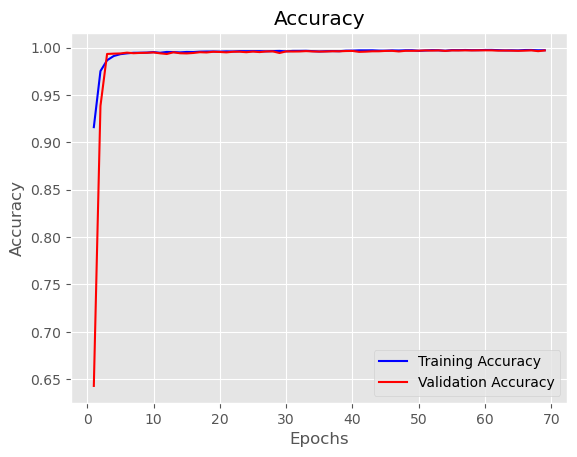

In [49]:
import matplotlib.pyplot as plt

# Get accuracy values from the history object
accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']

# Get the number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot accuracy graph
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Loading previously trained Model

In [50]:
import tensorflow.keras.backend as K

def dice_coefficients_loss(y_true, y_pred):
    smooth = 1e-5
    intersection = K.sum(y_true * y_pred)
    dice_coef = (2.0 * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
    dice_coef_loss = 1.0 - dice_coef
    return dice_coef_loss

def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou_score = (intersection + 1e-7) / (union + 1e-7)
    return iou_score

def dice_coefficients(y_true, y_pred):
    smooth = 1e-5
    intersection = K.sum(y_true * y_pred)
    dice_coef = (2.0 * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
    return dice_coef

In [52]:
model = load_model(model_path, custom_objects=
                   {'dice_coefficients_loss': dice_coefficients_loss, 
                    'iou': iou, 
                    'dice_coefficients': dice_coefficients  
                   } )

In [53]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width)  )

In [54]:
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

Found 589 validated image filenames.
Found 589 validated image filenames.
98/98 [==============================] - 15s 149ms/step - loss: 0.2283 - binary_accuracy: 0.9974 - iou: 0.6801 - dice_coefficients: 0.7730


In [55]:
print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )

Test Loss  0.2282530665397644
Test IoU  0.9973611831665039
Test Dice Coefficient  0.6800958514213562


In [56]:
df_result = pd.DataFrame()
df_result['test_loss'] = [results[0]]
df_result['test_iou'] = [results[1]]
df_result['test_dice_coefficient'] = [results[2]]
df_result.to_csv(test_result_file_path, index=False)

# Plotting Predicted Masks Segmentation results from the Test Image set

1/1 [==============================] - 0s 16ms/step


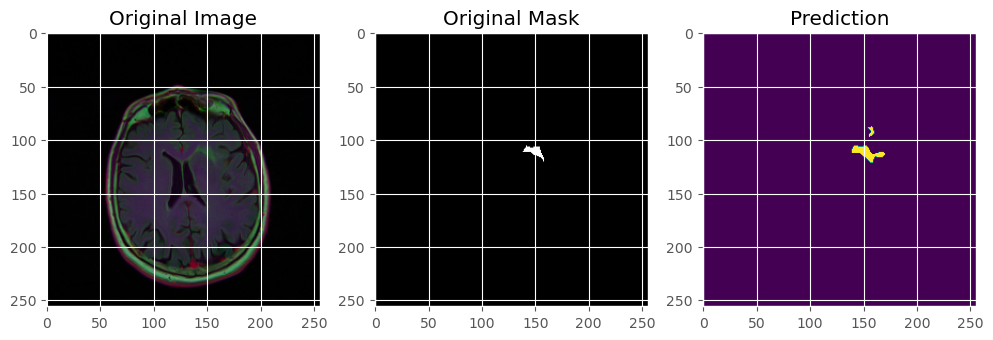

1/1 [==============================] - 0s 20ms/step


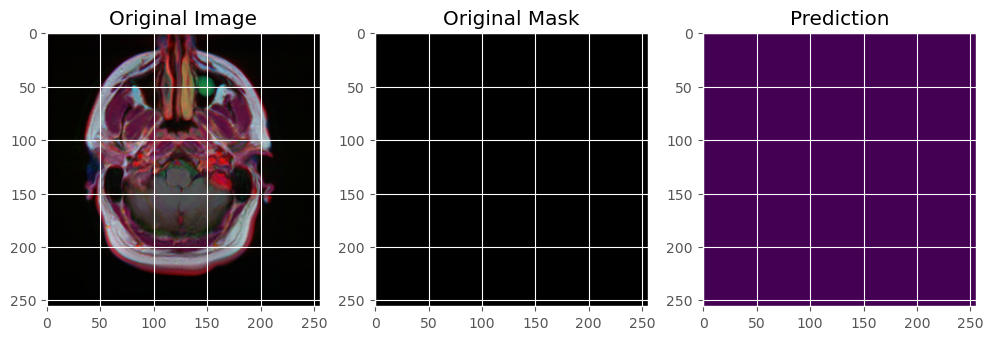

1/1 [==============================] - 0s 24ms/step


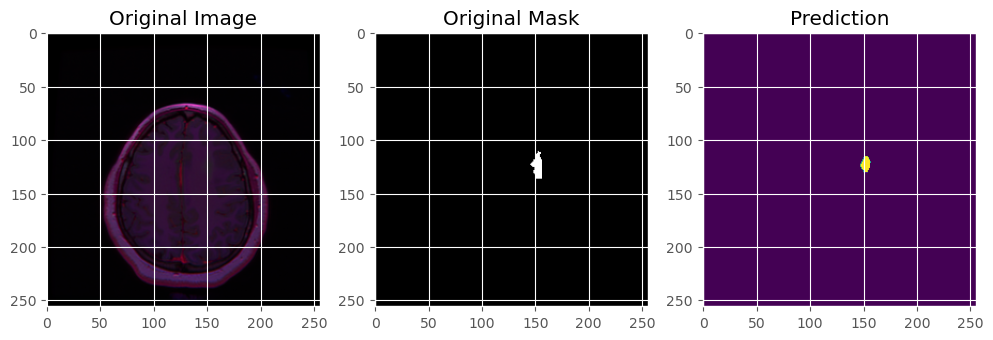

1/1 [==============================] - 0s 28ms/step


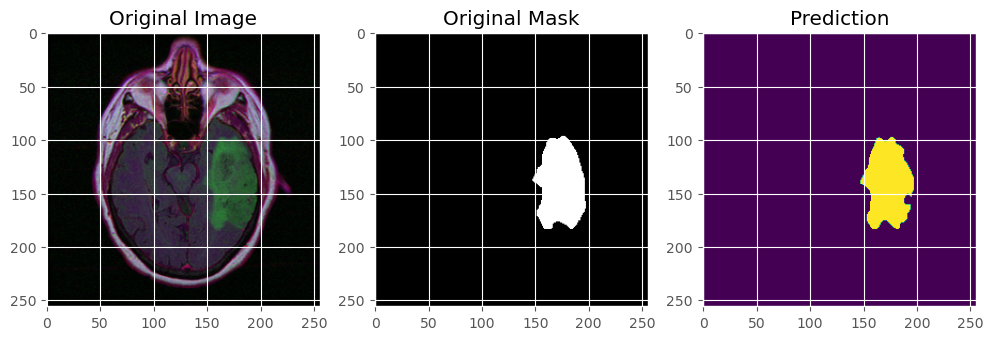

1/1 [==============================] - 0s 28ms/step


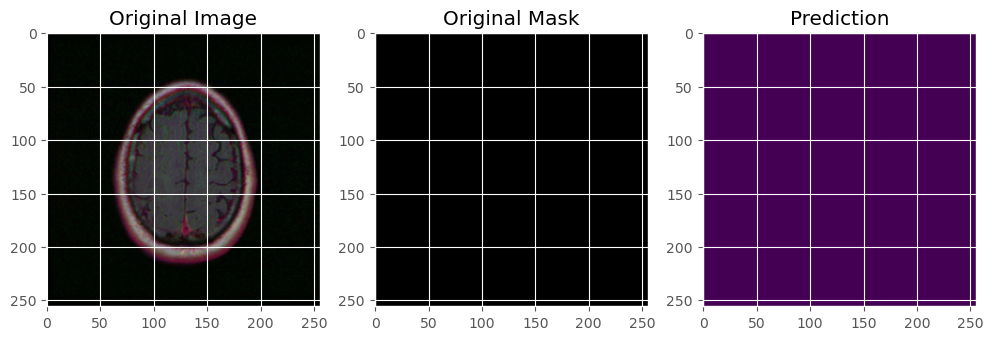

1/1 [==============================] - 0s 24ms/step


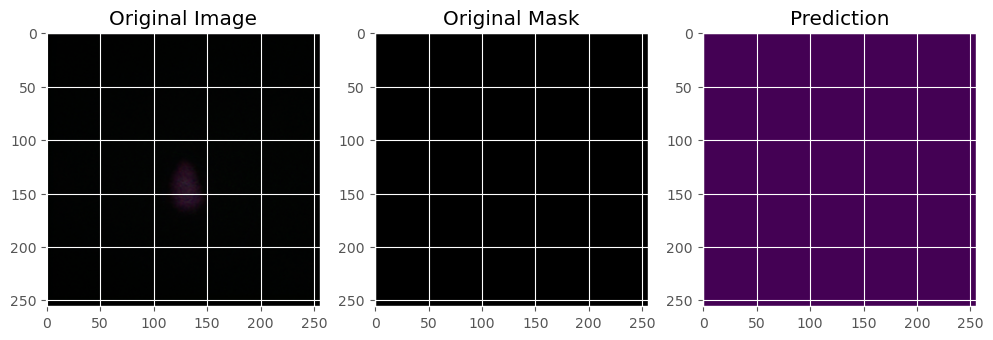

1/1 [==============================] - 0s 20ms/step


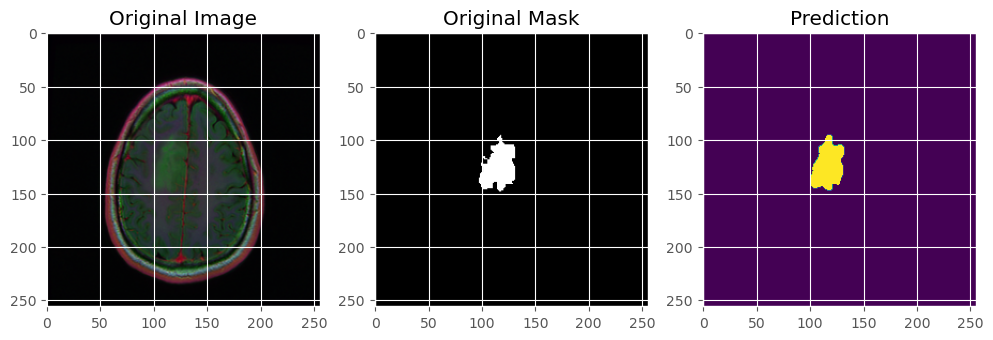

1/1 [==============================] - 0s 20ms/step


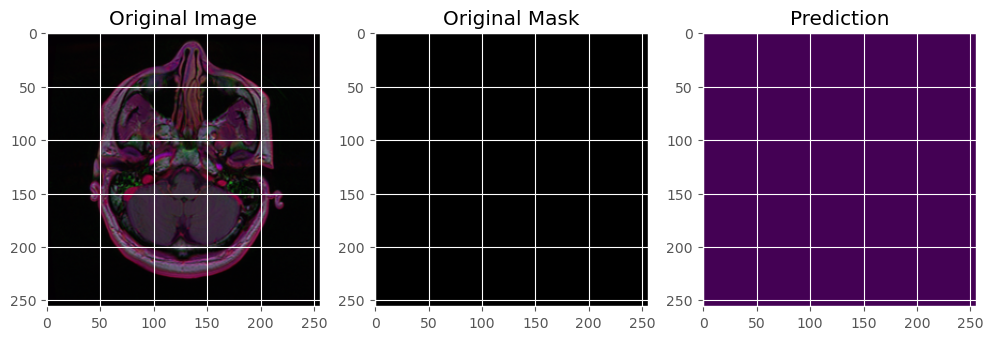

1/1 [==============================] - 0s 20ms/step


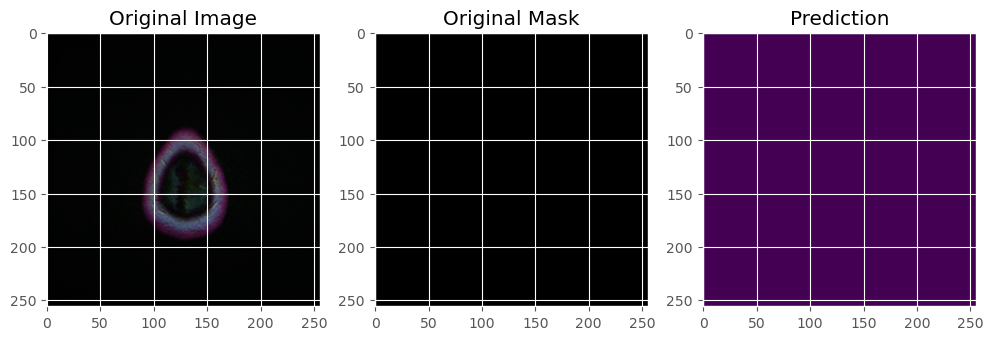

1/1 [==============================] - 0s 28ms/step


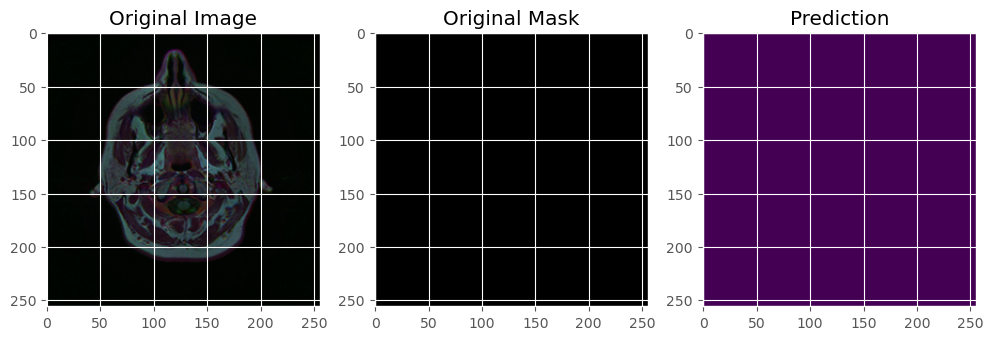

1/1 [==============================] - 0s 20ms/step


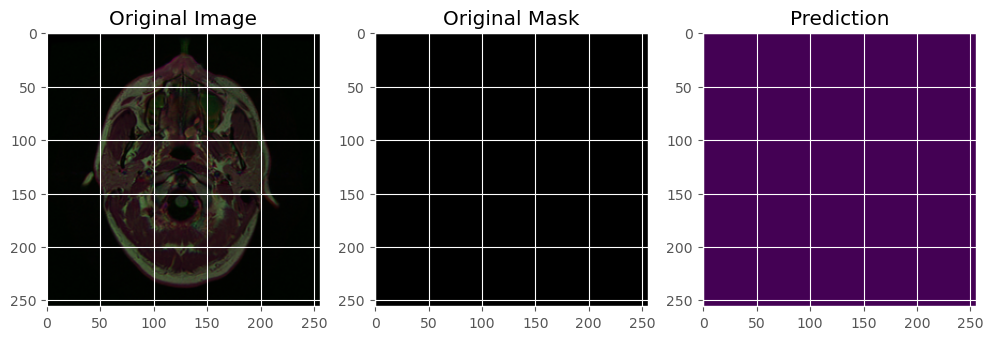

1/1 [==============================] - 0s 24ms/step


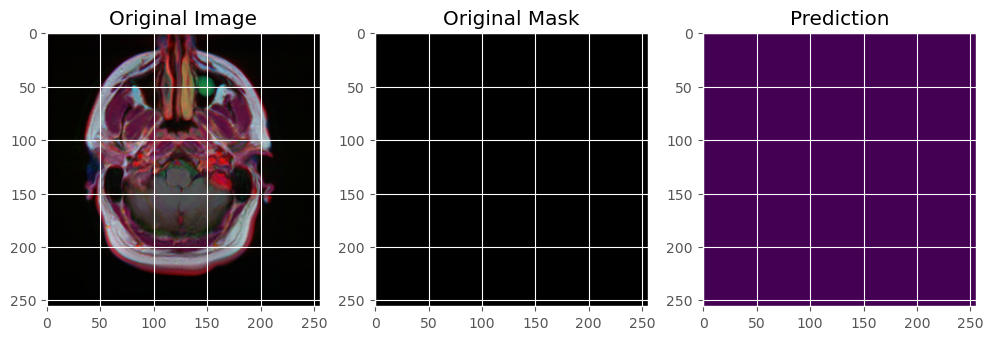

1/1 [==============================] - 0s 28ms/step


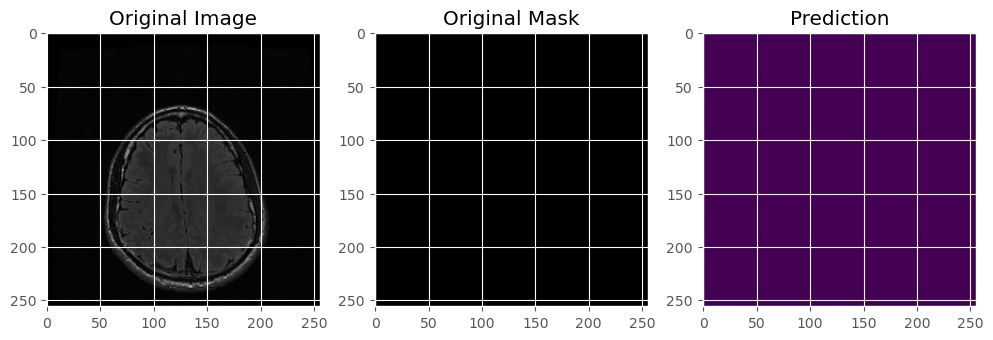

1/1 [==============================] - 0s 24ms/step


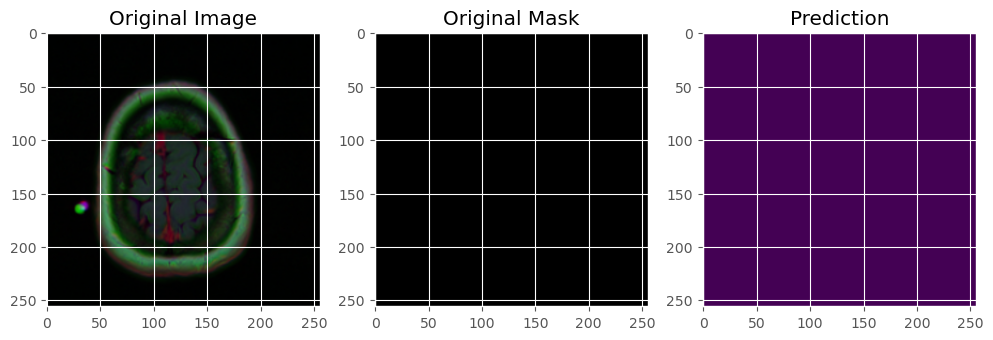

1/1 [==============================] - 0s 24ms/step


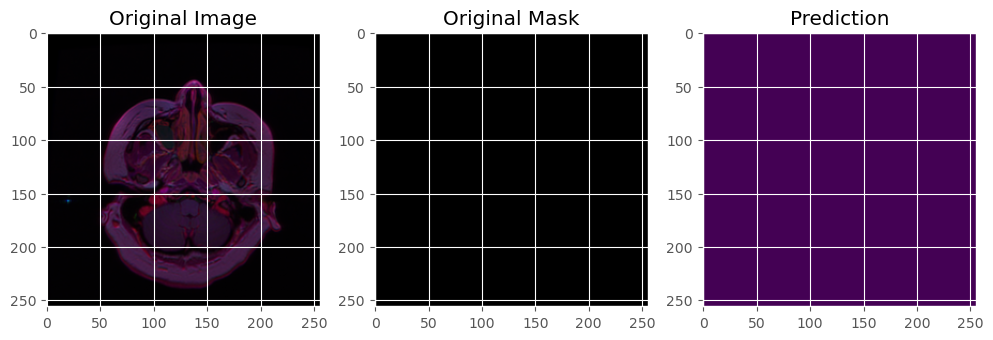

1/1 [==============================] - 0s 28ms/step


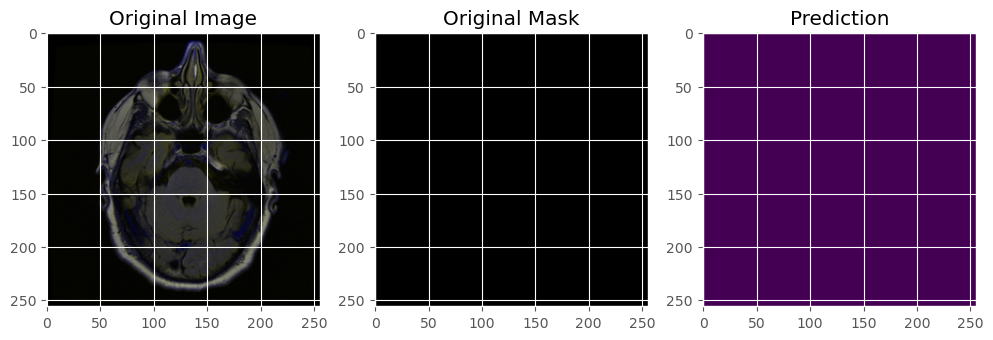

1/1 [==============================] - 0s 24ms/step


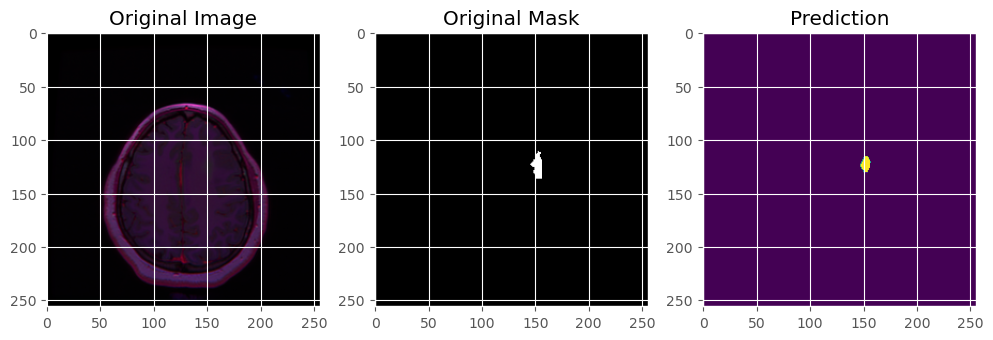

1/1 [==============================] - 0s 20ms/step


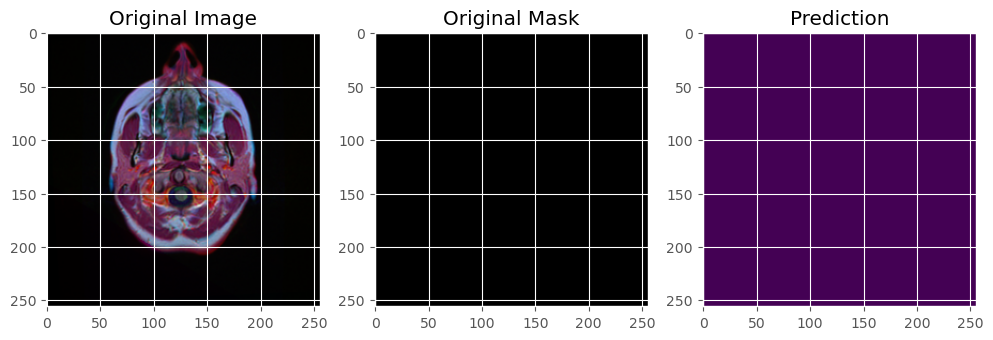

1/1 [==============================] - 0s 24ms/step


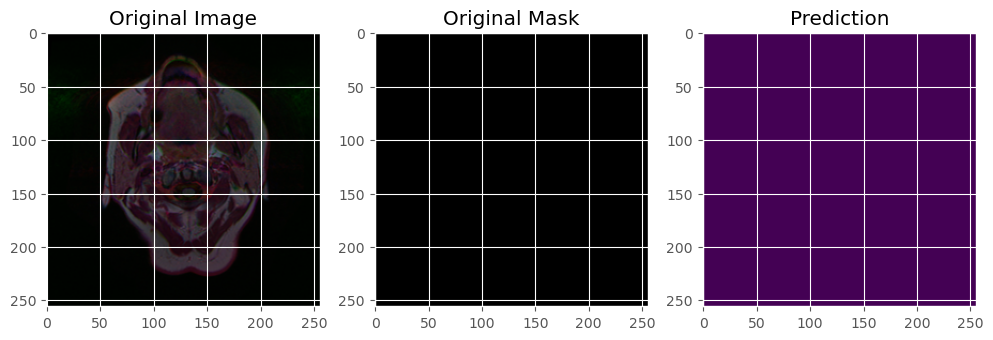

1/1 [==============================] - 0s 20ms/step


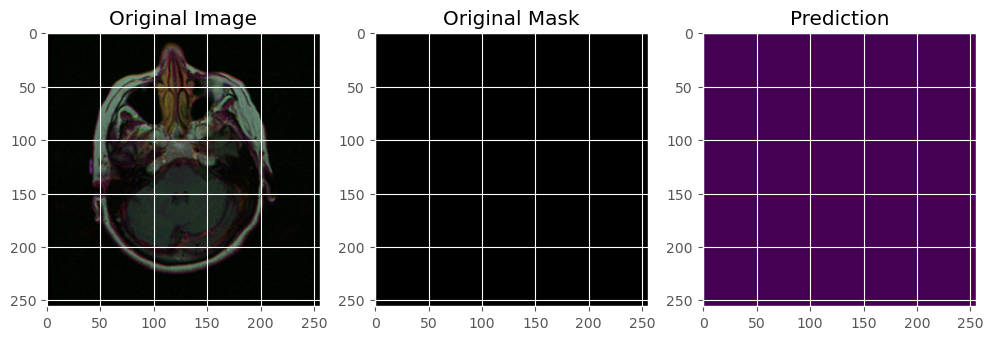

In [58]:
import numpy as np


for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()

1/1 [==============================] - 0s 28ms/step


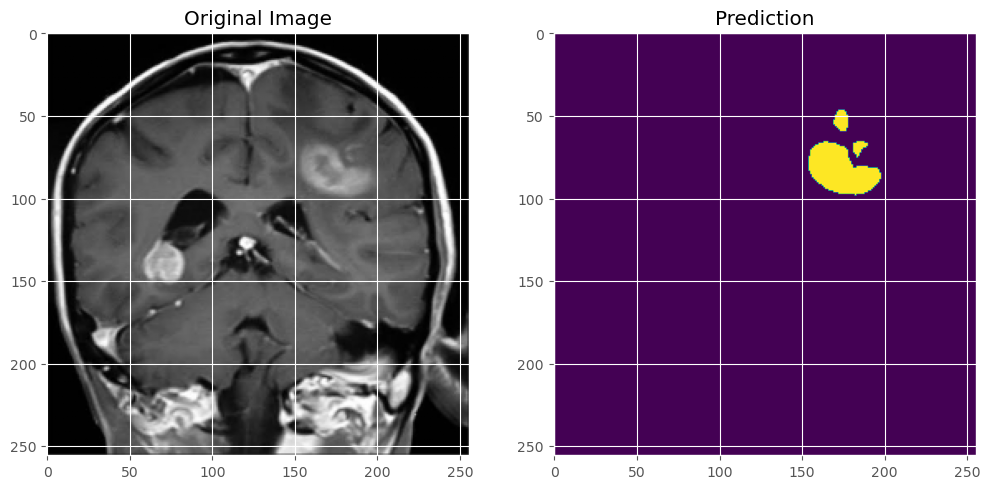

In [74]:
import numpy as np

index = np.random.randint(1, len(df_test.index))
image_path = df_test['image_filenames_train'].iloc[index]

img = cv2.imread("C:/Users/gurma/Desktop/ty.jpeg")
img = cv2.resize(img, (im_height, im_width))
img = img / 255
img = img[np.newaxis, :, :, :]

predicted_mask = model.predict(img)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(img))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(predicted_mask) > 0.5)
plt.title('Prediction')
plt.show()
